![title](imgs/explicationGlobalesWP.png)
L'objectif de ce notebook est de présenter un exemple de fonctionnement d'une **pripeline de classification d'intent** au sein d'un moteur NLP.


In [131]:
from sklearn.datasets import fetch_20newsgroups
import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import copy
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn_evaluation.plot import confusion_matrix

Une telle pipeline se divise en trois étapes :
- Tokenization (séparation de la phrase en mot)
- Featurization/ Vectorisation (création des vecteurs de phrases)
- Classification (labellisation des phrases)
----

![title](imgs/explicationMLIntentsWP.png)


------

# Vectorisation
La première étape de classification consiste a **vectoriser** les données (phrases). Ces vecteurs peuvent être:
- **pré-entrainés** à l'aide des données issus de http://commoncrawl.org/ (**spaCy**)
- un modèle word2Vec peut être **créé** (**Gensim**)
- Une vectorisation basée sur la méthode **Bag Of Words (CountVectorizer + TF-IDF)** peut être utilisée
![title](imgs/VectorizationWP.png)




In [150]:
spacy_model_name='en'
nlp = spacy.load('en', disable = ['tagger','parser','ner','textcat'])

Cette méthode permet de **moyenner les vecteurs** associés aux mots d'une phrase à partir d'un modèle **Word2Vec** entraîné

In [161]:
def getWord2VecVectors(xTokenized,y, model, deleteNullVectoreSentances = False):
    shape = (model.wv.vector_size,)
    yOwnWord2VecModel = copy.deepcopy(y)


    xOwnWord2VecModel = []
    indexesToDelete = [] 

    for (indexToDelete,sent) in enumerate(xTokenized) : 
        sumForSent = np.zeros(shape)
        nrAdded = 0
        for word in sent:
            if model.wv.vocab.has_key(word):
                nrAdded += 1
                sumForSent += model.wv[word]
        if nrAdded != 0 : 
            xOwnWord2VecModel.append(np.divide(sumForSent, nrAdded))
        else :
            if deleteNullVectoreSentances :
                indexesToDelete.append(indexToDelete)
            else : 
                xOwnWord2VecModel.append(sumForSent) #We add the zero vector for this sentance

    if deleteNullVectoreSentances : 
        for i in sorted(indexesToDelete, reverse=True):
            yOwnWord2VecModel = np.delete(yOwnWord2VecModel, i)
    return (xOwnWord2VecModel,yOwnWord2VecModel)

In [162]:
def printReport(gridSearch,x,y):
    y_true, y_predFull = y, gridSearch.predict(x)
    print(classification_report(y_true, y_predFull))

## Chargement des données
Ici on charge les données issus du dataset **20 newsgroups**  http://scikit-learn.org/stable/datasets/twenty_newsgroups.html associé aux **6 catgéories** 'sci.space', 'sci.electronics', comp.sys.mac.hardware', 'comp.windows.x', 'rec.sport.baseball', 'rec.sport.hockey'

In [240]:
categories = [
    'sci.space',
    'sci.electronics',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'rec.sport.baseball',
    'rec.sport.hockey'
    
    
]
newsData = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
print("%d documents" % len(newsData.filenames))
print("%d categories" % len(newsData.target_names))

3552 documents
6 categories


## Les vecteurs d'entrées sont de trois formes :
- **xFull** permettra d'entraîner une pipeline basée sur **CountVectorizer** qui prendra en entrée un ensemble de phrases
- **xTokenized** permettra d'entrainer notre propre modèle word2Vec
- **xGloVe** utilisera les vecteurs pré-entraîné issus de spaCy (et de Common Crawl)

In [241]:
xFull = newsData.data
target_names = newsData.target_names
y = newsData.target
xTokenized = []
xGloVe = []
for news in newsData.data: 
    doc = nlp(unicode(news))
    xGloVe.append(doc.vector)
    xTokenized.append([token.text for token in iter(doc)])

On **divise** nos données en **jeu de test** et d'**entraînement** pour évaluer nos modèles

In [242]:
xFullTrain, xFullTest, yFullTrain, yFullTest = train_test_split(
    xFull, y, test_size=0.3, random_state=42)
xTokenizedTrain, xTokenizedTest, yTokenizedTrain, yTokenizedTest = train_test_split(
    xTokenized, y, test_size=0.3, random_state=42)
xGloVeTrain, xGloVeTest, yGloVeTrain, yGloVeTest = train_test_split(
    xGloVe, y, test_size=0.3, random_state=42)
yTest = yGloVeTest
yTrain = yGloVeTrain

-----

## Création du modèle word2Vec entraîné sur nos données
- size : correspond aux nombre de features que l'on veut (donc aux nombres de neurones dans la couche cachée
- window : la fenêtre de selection des mots dans le contexte
- min_count : le nombre minimum d'apparition nécessaire d'un mot pour le considéré dans le vocabulaire

In [262]:
modelWord2Vec = Word2Vec(xTokenizedTrain, size=100, window=5, min_count=5, sg=1)

### Testons le modèle
On teste le modèle en regardant les mots qu'il considère comme les plus proches du mot "space", le modèle semble donner des résultats logiques puisque "research", "station" et "shuttle" sont retournés.

In [266]:
modelWord2Vec.wv.most_similar("space")

[(u'research', 0.8191206455230713),
 (u'station', 0.8022928833961487),
 (u'shuttle', 0.7992041707038879),
 (u'lunar', 0.7868685126304626),
 (u'development', 0.783505916595459),
 (u'launch', 0.7833254337310791),
 (u'technical', 0.7800613641738892),
 (u'various', 0.7703723311424255),
 (u'exploration', 0.7679097056388855),
 (u'technology', 0.7610211372375488)]

In [274]:
xOwnWord2VecModelTrain, yOwnWord2VecModelTrain = getWord2VecVectors(xTokenizedTrain,yTokenizedTrain,modelWord2Vec)

In [275]:
xOwnWord2VecModelTest, yOwnWord2VecModelTest = getWord2VecVectors(xTokenizedTest,yTokenizedTest,modelWord2Vec)

# Classification

On définit ici les **paramètres** liés aux composants de notre pipeline de machine learning d'extraction d'intents

In [216]:
parametersFull = {
    'vect__ngram_range': ([(1,1),(1, 2)]),  # unigrammes ou bigrammes
    'clf__C': [1,2,5,10], #coefficient de perte 
}
parametersClf = {
    'clf__C': [1,2,5,10],
}

## Définition des pipelines d'extraction d'intents
- pipelineFull : utilisera le modèle **Bag Of Words** de réprésentation des pĥrases
- pipelineClf : permettra de tester nos modèles **Word2Vec** (pré-entraîné de **spaCy** ou entraîné avec **Gensim**)

In [217]:
pipelineFull = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])
pipelineClf = Pipeline([
    ('clf', LinearSVC()),
])


### Gridsearch et recherche des meilleurs hyperparamètres
L'utilisation de **GridSearch** permet de selectionner les meilleurs paramètres liés à nos pipelines pour nos données d'entraînement

In [270]:
gridSearchFull = GridSearchCV(pipelineFull, parametersFull)
gridSearchGloVe = GridSearchCV(pipelineGloVe, parametersClf)
gridSearchOwnedWord2Vec = GridSearchCV(pipelineGloVe, parametersClf)

In [271]:
gridSearchFull.fit(xFullTrain,yTrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__analyzer': ['word'], 'clf__C': [1, 2, 5, 10], 'clf__max_iter': (10, 50, 80)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [272]:
gridSearchGloVe.fit(xGloVeTrain,yTrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [1, 2, 5, 10], 'clf__max_iter': (10, 50, 80)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [276]:
gridSearchOwnedWord2Vec.fit(xOwnWord2VecModelTrain,yTrain)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [1, 2, 5, 10], 'clf__max_iter': (10, 50, 80)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## Évaluation des pipelines
----
Les rapports donnent les informations de précision et de rappel des différents classificateurs, on présente aussi les matrices de confusions associées.
Pour comprendre les différentes valeurs présentes, on peut se référer à ce schéma :
![dd](imgs/Precisionrecall.svg)


In [277]:
printReport(gridSearchFull,xFullTest,yTest)

             precision    recall  f1-score   support

          0       0.85      0.84      0.84       172
          1       0.92      0.98      0.94       167
          2       0.80      0.91      0.85       170
          3       0.96      0.85      0.90       195
          4       0.85      0.83      0.84       189
          5       0.90      0.87      0.89       173

avg / total       0.88      0.88      0.88      1066



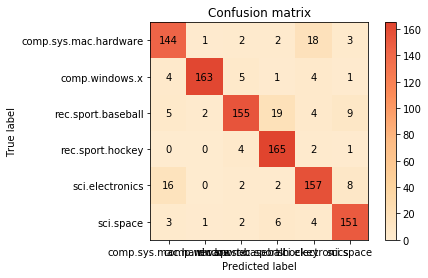

In [278]:
confusion_matrix(gridSearchFull.predict(xFullTest),yTest, target_names)

In [279]:
printReport(gridSearchGloVe,xGloVeTest,yTest)

             precision    recall  f1-score   support

          0       0.77      0.77      0.77       172
          1       0.84      0.92      0.87       167
          2       0.80      0.88      0.83       170
          3       0.92      0.81      0.86       195
          4       0.86      0.78      0.82       189
          5       0.82      0.88      0.85       173

avg / total       0.84      0.83      0.83      1066



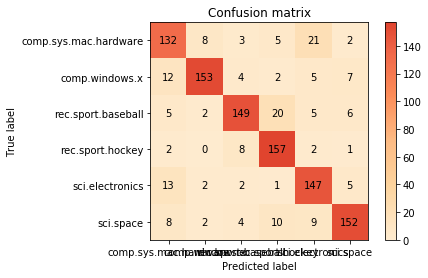

In [280]:
confusion_matrix(gridSearchGloVe.predict(xGloVeTest),yTest, target_names)

In [281]:
printReport(gridSearchOwnedWord2Vec,xOwnWord2VecModelTest,yOwnWord2VecModelTest)

             precision    recall  f1-score   support

          0       0.56      0.62      0.59       172
          1       0.69      0.90      0.78       167
          2       0.52      0.57      0.54       170
          3       0.67      0.59      0.63       195
          4       0.63      0.28      0.39       189
          5       0.56      0.71      0.62       173

avg / total       0.61      0.60      0.59      1066



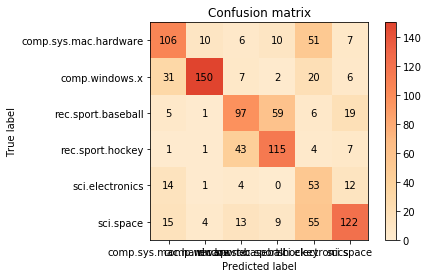

In [282]:
confusion_matrix(gridSearchOwnedWord2Vec.predict(xOwnWord2VecModelTest),yTest, target_names)

### Analyse des résultats
- Les pipelines utilisant la vectorization **Bag of Words** et le modèle **GloVe** pré-entraînés performent de façon quasi équivalente
- Celle utilisant un modèle **Word2Vec** entraîné sur nos données performe moins bien : le nombre de données pour entraîner notre modèle n'est pas assez important

-----
## Explication des résultats du classificateur basé sur Bag Of Words
On utilise la bibliothèque **eli5** qui permet de rentrer dans le fonctionnement des classificateurs basés sur des SVM (support vector machine)

In [225]:
import eli5

In [283]:
vectorizer = gridSearchFull.best_estimator_.named_steps["vect"]

classifier = gridSearchFull.best_estimator_.named_steps["clf"]

### Poids du classificateur
On présente ici les **poids** associés aux différents mots les plus influents sur la classification dans telle ou telle catégorie. Les mots **"mac" et "apple"** sont ceux qui influencent le plus la classification d'un article dans la classe **comp.sys.mac.hardware**, ce qui semble logique

In [284]:
eli5.show_weights(classifier, target_names=target_names, vec=vectorizer, top=20)

-------
### Exemple de classification sur un exemple issu de la catégorie sci.space
Sur cet exemple le meilleur score est obtenu pour la catégorie sci.space, ce qui explique que le classificateur classifie bien cet exemple

In [287]:
gridSearchFull.predict([xFullTest[8]])[0] == yTest[8]

True

In [289]:
eli5.show_prediction(classifier, xFullTest[8], vec=vectorizer, target_names=target_names)